In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import random

In [2]:
df = pd.read_csv('/content/logs.csv')[0:1000]
df[['RequestResponseLogDuration']] = df[['RequestResponseLogDuration']].apply(pd.to_numeric)
df.head()

timestamp  RequestResponseLogDuration
0         -23T00:04:21.896Z                        31.0
1  2021-08-23T00:00:32.969Z                        31.0
2  2021-08-23T00:06:27.132Z                        47.0
3  2021-08-23T00:02:41.443Z                        47.0
4  2021-08-23T00:07:44.475Z                        62.0

In [3]:
def randomiseMissingData(df2):
    "randomise missing data for DataFrame (within a column)"
    df = df2.copy()
    for col in df.columns:
        data = df[col]
        mask = data.isnull()
        print(mask[4:100])
        samples = random.choices( data[~mask].values , k = mask.sum() )
        data[mask] = samples

    return df

In [4]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
print(len(df [['RequestResponseLogDuration']]))
model.fit(df[['RequestResponseLogDuration']])
df['scores']=model.decision_function(df[['RequestResponseLogDuration']])
df['anomaly']=model.predict(df[['RequestResponseLogDuration']])
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(len(anomaly))


df.loc[df['anomaly'] == -1, 'RequestResponseLogDuration'] = np.nan


print(df[4:100])
#df[['RequestResponseLogDuration']] = np.where(df['anomaly'] == -1, 10)
df[['RequestResponseLogDuration']] = df[['RequestResponseLogDuration']].apply(pd.to_numeric)
df = randomiseMissingData(df)

print(len(df))


1000
76
                   timestamp  RequestResponseLogDuration    scores  anomaly
4   2021-08-23T00:07:44.475Z                        62.0  0.000000        1
5   2021-08-23T00:07:09.642Z                        31.0  0.129862        1
6   2021-08-23T00:06:51.132Z                        31.0  0.129862        1
7   2021-08-23T00:02:18.419Z                        16.0  0.149367        1
8   2021-08-23T00:19:33.395Z                         NaN -0.138186       -1
..                       ...                         ...       ...      ...
95  2021-08-23T03:11:50.768Z                        47.0  0.056950        1
96  2021-08-23T03:25:08.940Z                        16.0  0.149367        1
97  2021-08-23T03:24:58.925Z                        47.0  0.056950        1
98  2021-08-23T03:27:37.912Z                         NaN -0.058149       -1
99  2021-08-23T03:24:03.655Z                        62.0  0.000000        1

[96 rows x 4 columns]
4     False
5     False
6     False
7     False
8     Fal

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [5]:
features_3 = ['RequestResponseLogDuration']
#İlk 1000 datayı seçiyoruz. Çünkü çok fazla data seçersek, geçmişte çok fazla 
#Değeri az olan data pointler olduğu için prediction belli bir değerin altında
#çıkıyor.
print(anomaly_index)
features = df[features_3][0:1000]
features.index = df['timestamp'][0:1000]
features.head()
print(df[['RequestResponseLogDuration']][4:100])

[8, 9, 10, 19, 20, 27, 33, 34, 37, 47, 61, 66, 68, 71, 76, 79, 80, 85, 88, 98, 105, 107, 111, 123, 124, 133, 134, 135, 136, 137, 165, 166, 167, 171, 175, 176, 184, 226, 236, 262, 269, 283, 286, 301, 307, 330, 350, 369, 389, 396, 400, 445, 448, 458, 459, 464, 503, 504, 505, 530, 583, 603, 623, 634, 660, 698, 706, 723, 731, 762, 783, 813, 902, 918, 954, 990]
    RequestResponseLogDuration
4                         62.0
5                         31.0
6                         31.0
7                         16.0
8                         16.0
..                         ...
95                        47.0
96                        16.0
97                        47.0
98                        16.0
99                        62.0

[96 rows x 1 columns]


In [6]:
### standardize data
dataset = features.values
#300'den 700 e kadarki kısım bizim train datamız olacak. 
train_split = 700
tf.random.set_seed(18)

In [7]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False, t=0):
  data = []
  labels = []
 
  start_idx = start_idx + history_size
  if end_idx is None:
    
    end_idx = len(dataset)- target_size
  

  print(start_idx)
  print(end_idx)

  for i in range(start_idx , end_idx ):

    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
        labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
## plot train test loss 
def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()


In [10]:
future_target = 20 # 50 future values
history = 300
STEP = 20 #Eski 10 dataya bakarak gelecek 50 datayı tahmin etmeye çalışacağız.
#30 Adet 10 lenght'li listemiz olacak. (30*10 = 300 veriye bakacağız.)


#x_test_multi, y_test_multi = mutlivariate_data(dataset, dataset[:, 0],
#                                             train_split-200, 900, history,
#                                             future_target, STEP)

x_test_multi, y_test_multi = split_sequence(dataset[800:1000],STEP,future_target)

data_mean = x_test_multi.mean(axis =0)
data_std = x_test_multi.std(axis = 0)
x_test_multi = (x_test_multi - data_mean)/data_std


data_mean = y_test_multi.mean(axis =0)
data_std = y_test_multi.std(axis = 0)
y_test_multi = (y_test_multi - data_mean)/data_std


print(x_test_multi.shape)

(161, 20, 1)


In [11]:
#x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 0], 0,
#                                                 train_split, history,
#                                                 future_target, STEP)
#x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 0],
#                                             train_split-300, 800, history,
#                                             future_target, STEP)

x_train_multi, y_train_multi = split_sequence(dataset[0:600],STEP,future_target)
x_val_multi, y_val_multi = split_sequence(dataset[600:800],STEP,future_target)

data_mean = x_train_multi.mean(axis =0)
data_std = x_train_multi.std(axis = 0)
x_val_multi = (x_val_multi - data_mean)/data_std


data_mean = y_train_multi.mean(axis =0)
data_std = y_train_multi.std(axis = 0)
y_val_multi = (y_val_multi - data_mean)/data_std



######################################################

data_mean = x_train_multi.mean(axis =0)
data_std = x_train_multi.std(axis = 0)
x_train_multi = (x_train_multi - data_mean)/data_std



data_mean = y_train_multi.mean(axis = 0)
data_std = y_train_multi.std(axis = 0)
y_train_multi = (y_train_multi - data_mean)/data_std


print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(561, 20, 1)
(561, 20, 1)
(161, 20, 1)
(161, 20, 1)


In [12]:
# TF DATASET
batch_size = 64
buffer_size = 1000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size)

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size)

test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(batch_size)

print(train_data_multi)
print(x_train_multi.shape)



<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None))>
(561, 20, 1)


In [13]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt


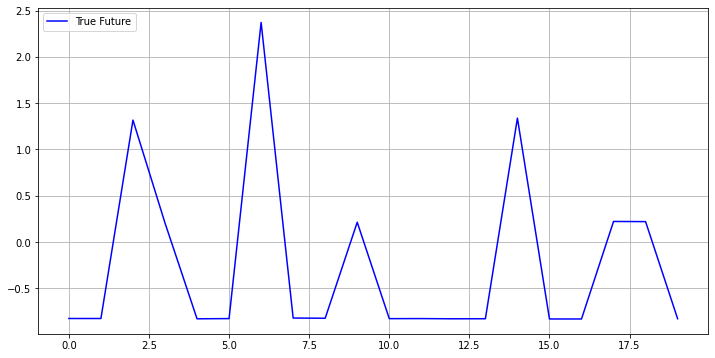

In [14]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(np.arange(num_out), np.array(true_future), 'b',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[1], y[1], np.array([0]))

In [ ]:
EPOCHS = 500
steps = int( np.ceil(x_train_multi.shape[0] / batch_size) )
val_steps=int( np.ceil(x_val_multi.shape[0] / batch_size) )

from keras.layers import Dropout

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(128,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(128,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(64,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=False))
multi_step_model.add(Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(20)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_model.summary()
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 64)            16896     
                                                                 
 lstm_9 (LSTM)               (None, 20, 128)           98816     
                                                                 
 lstm_10 (LSTM)              (None, 20, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1300      
                                                                 
Total params: 298,004
Trainable params: 298,004
Non-tr

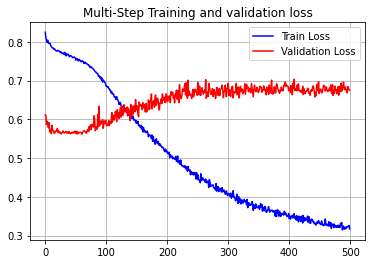

In [20]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')

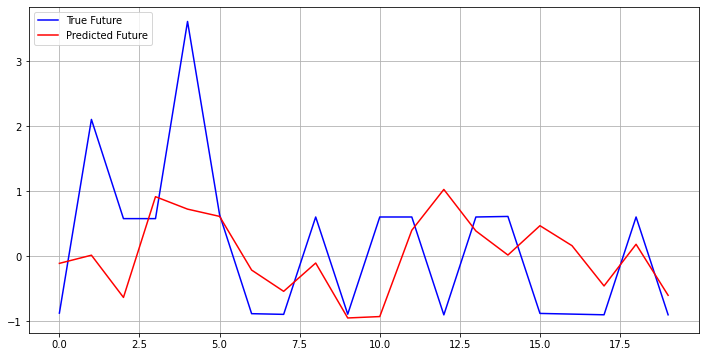

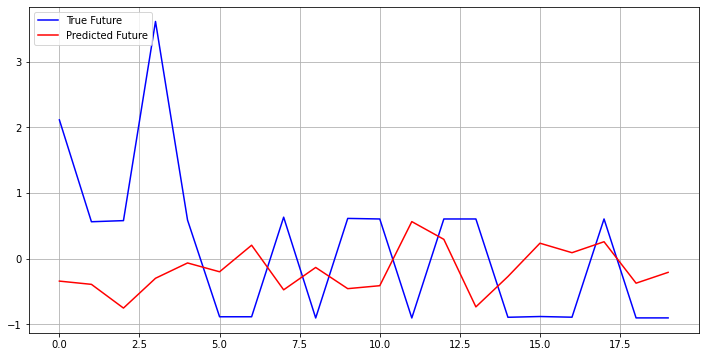

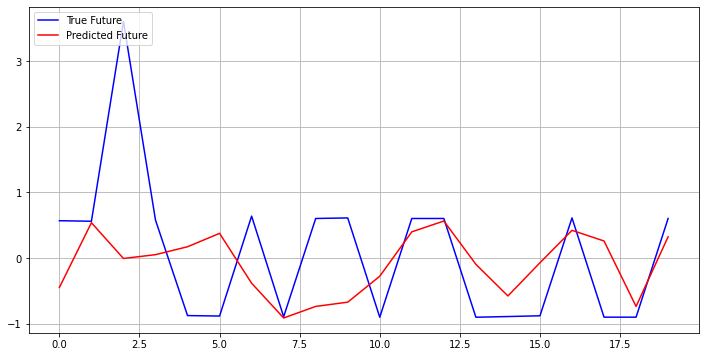

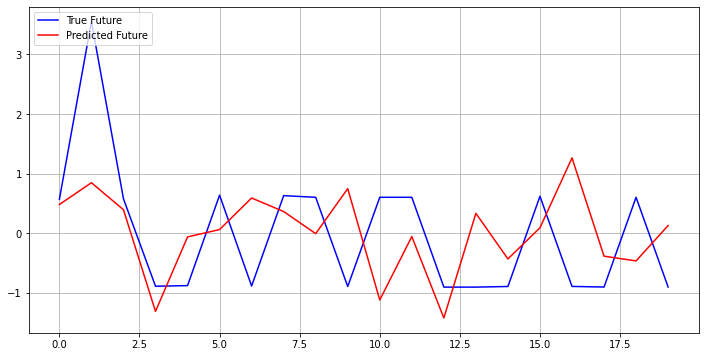

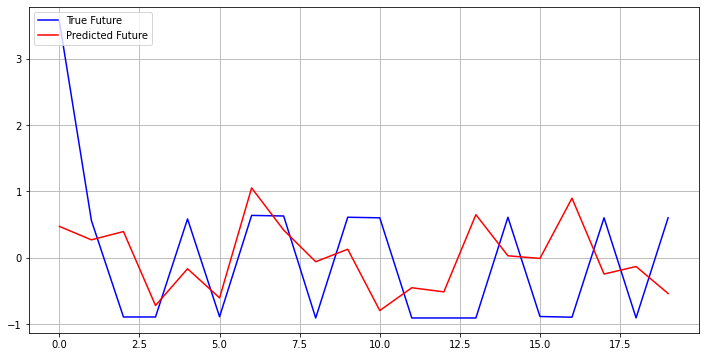

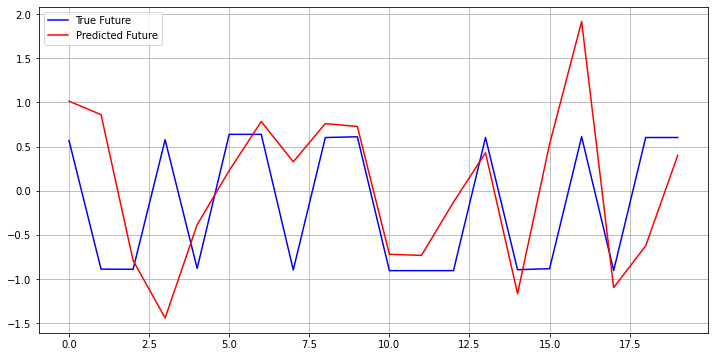

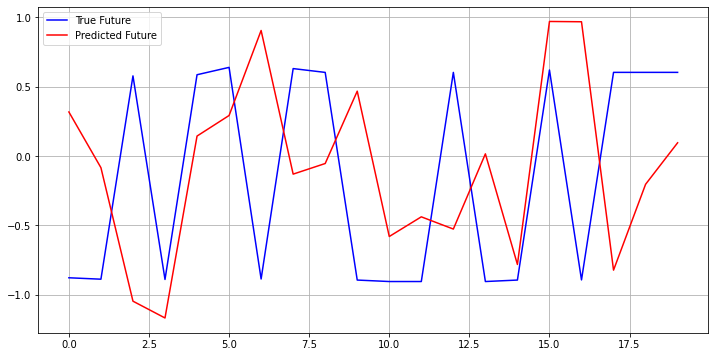

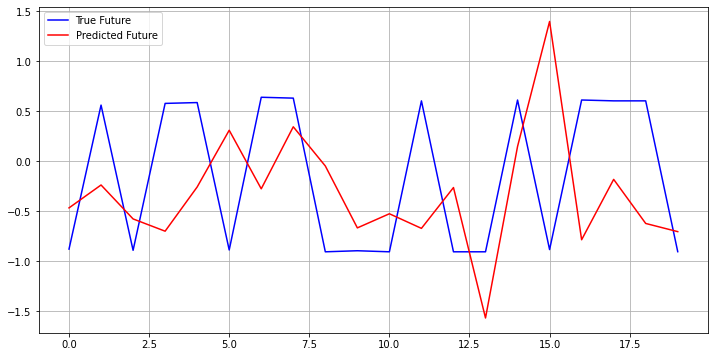

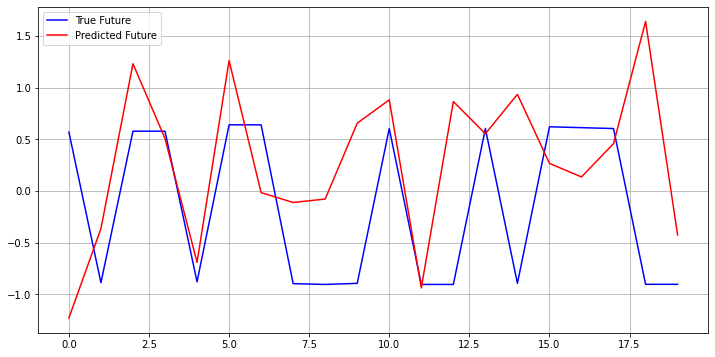

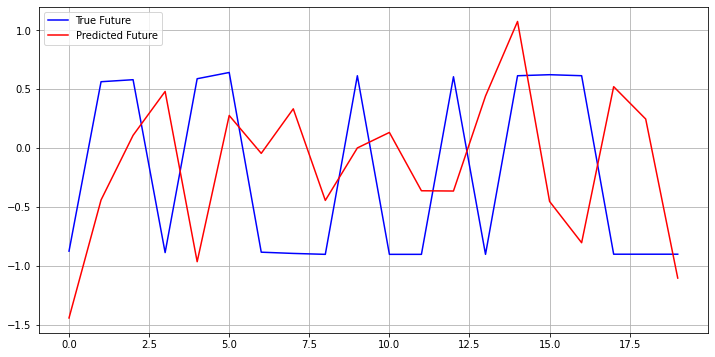

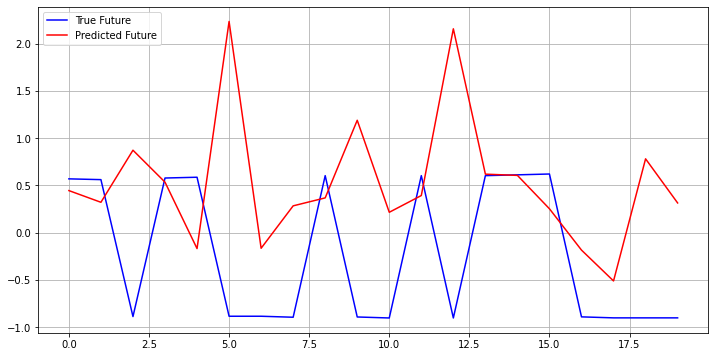

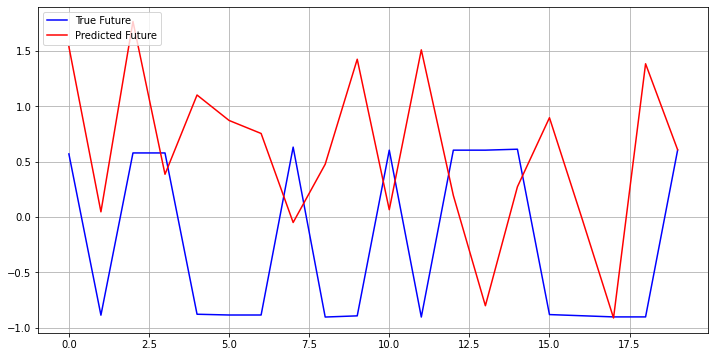

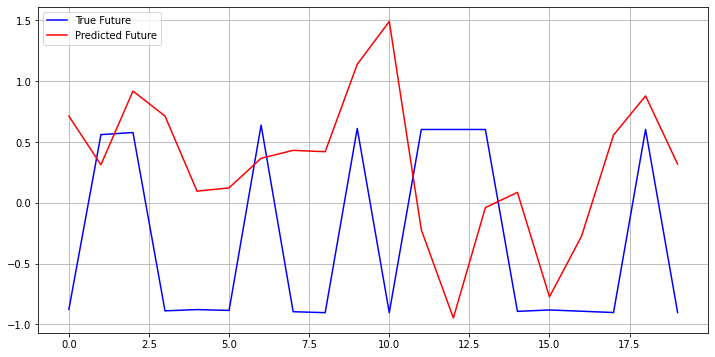

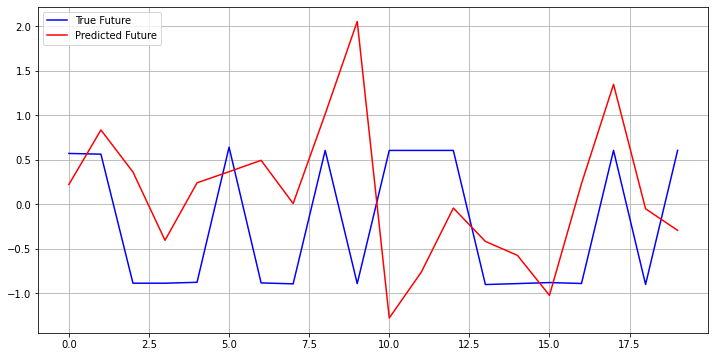

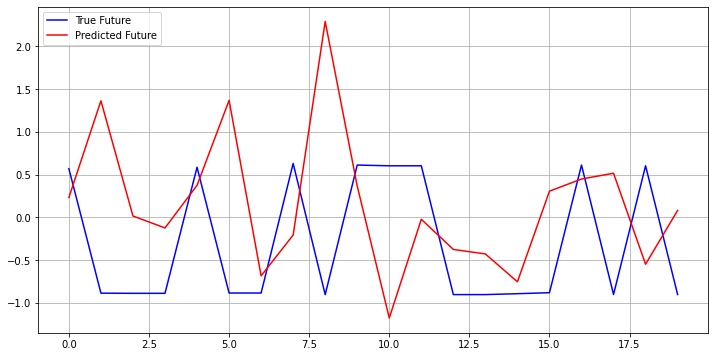

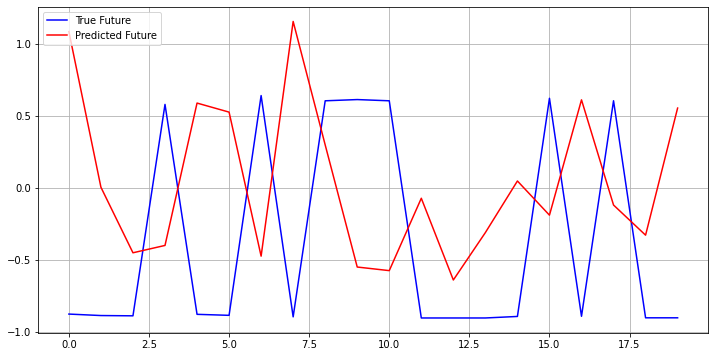

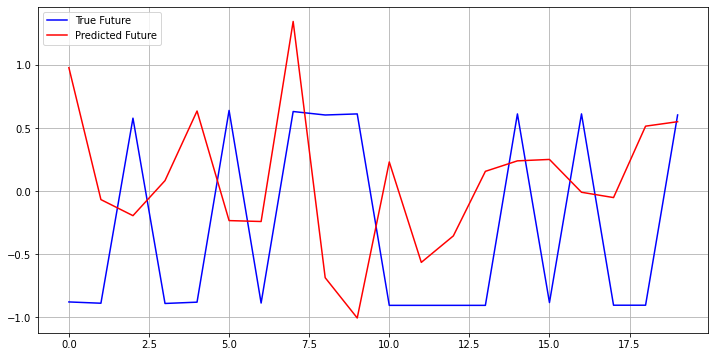

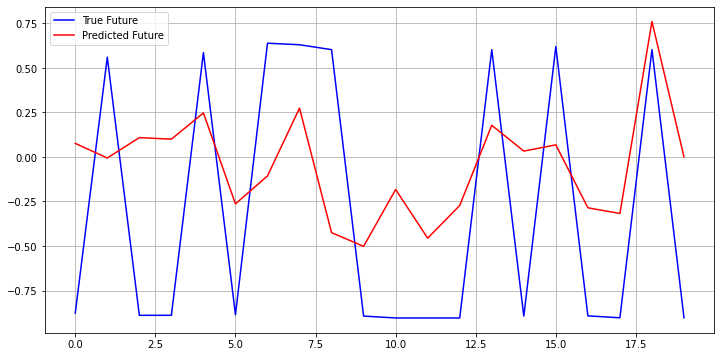

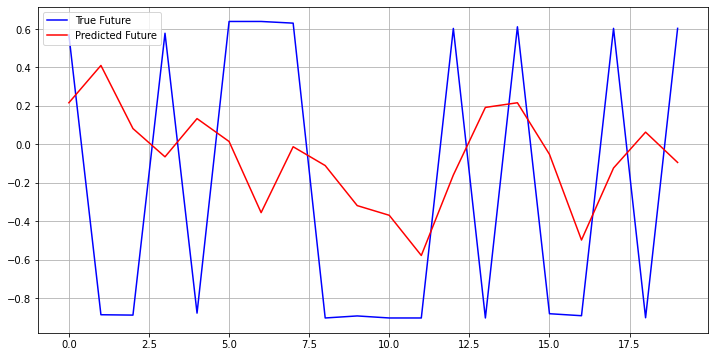

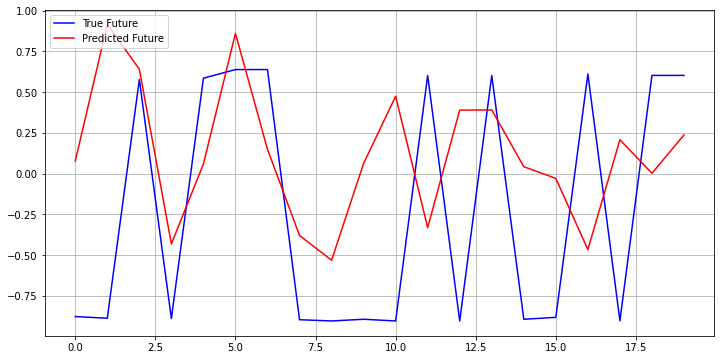

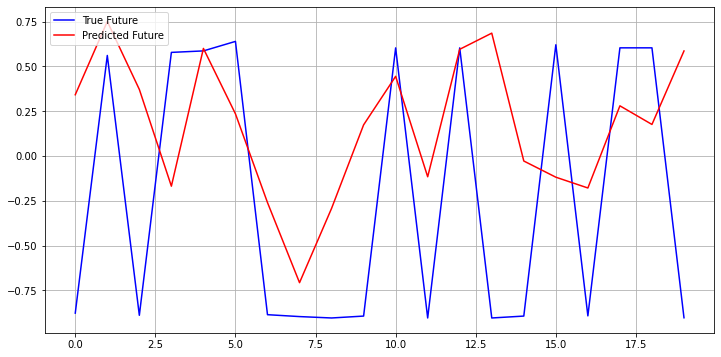

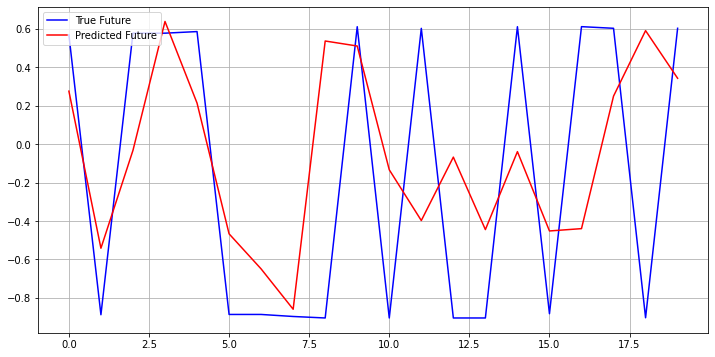

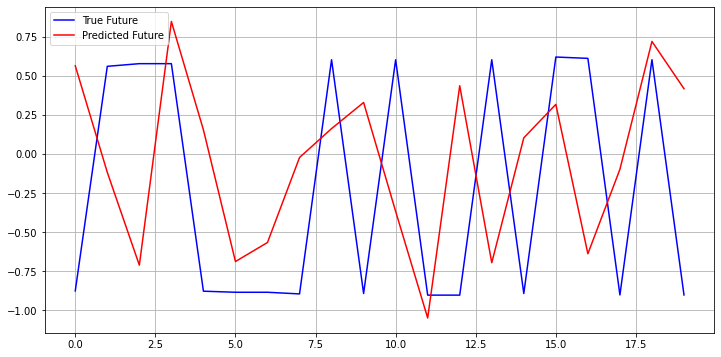

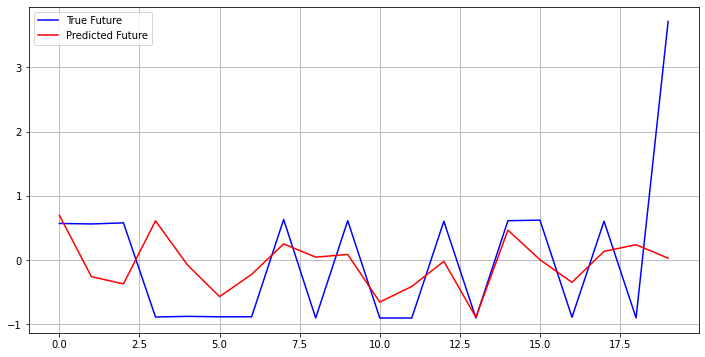

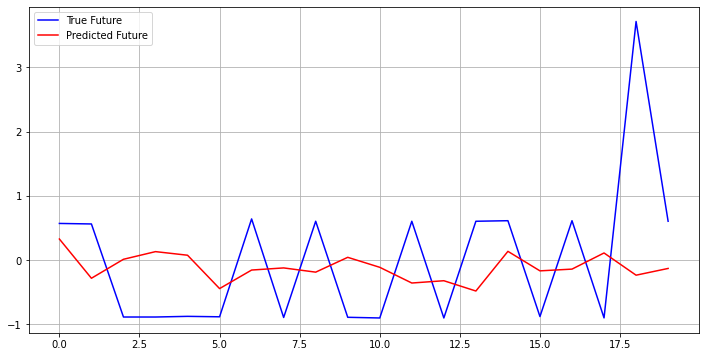

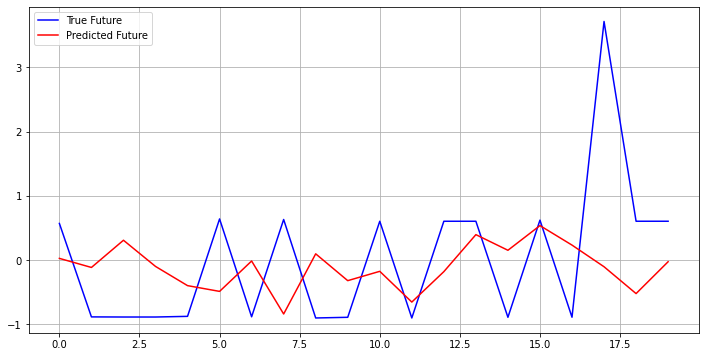

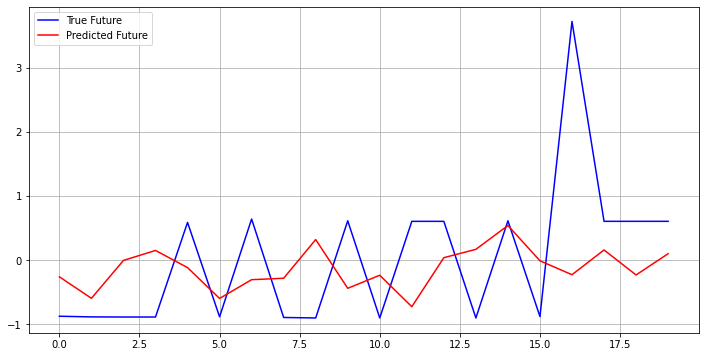

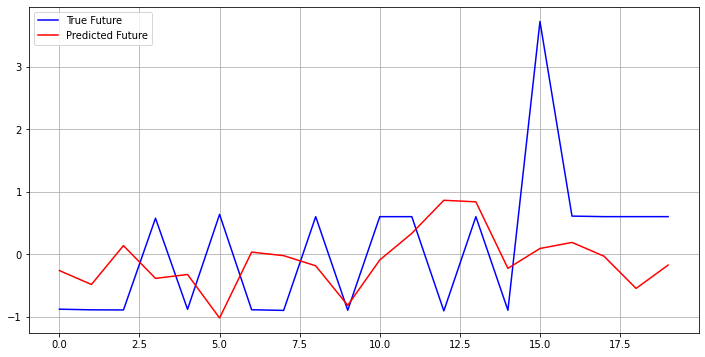

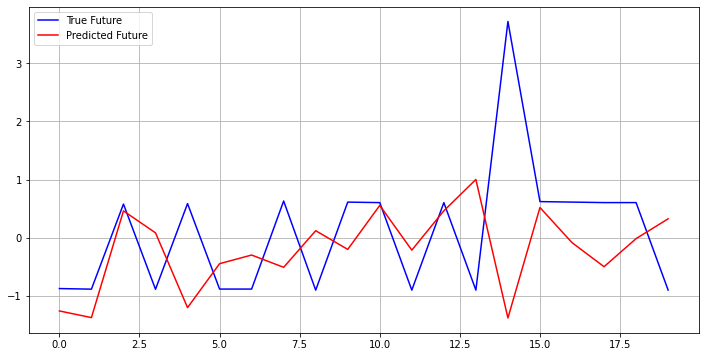

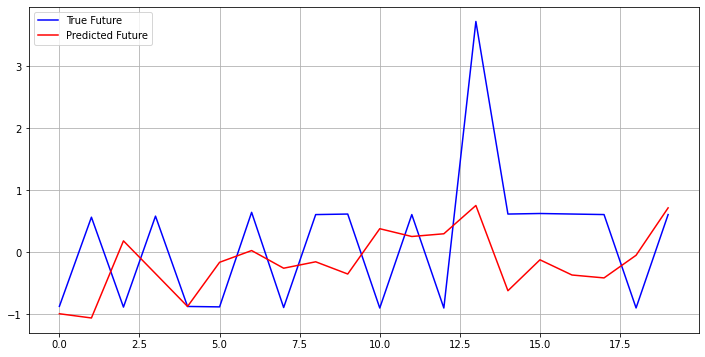

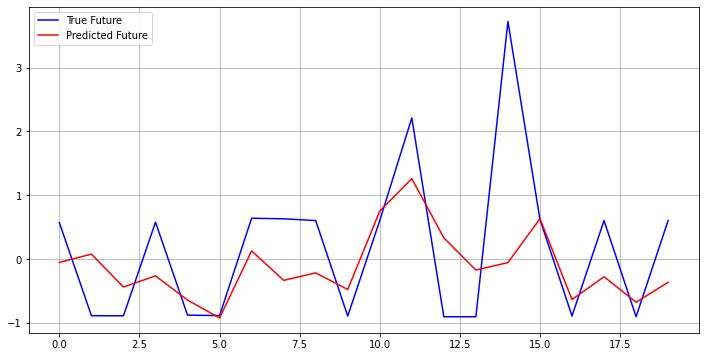

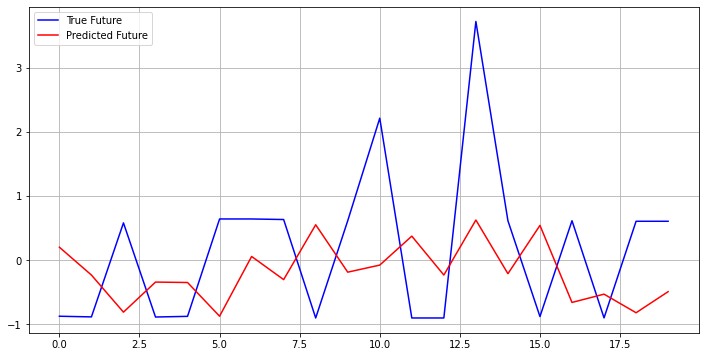

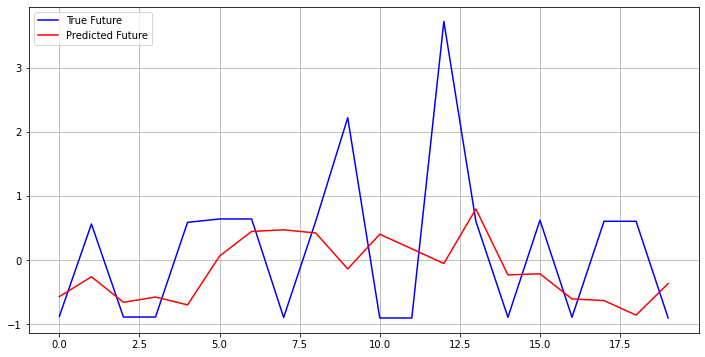

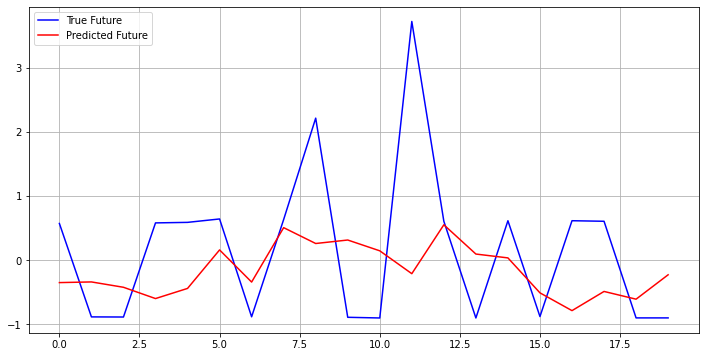

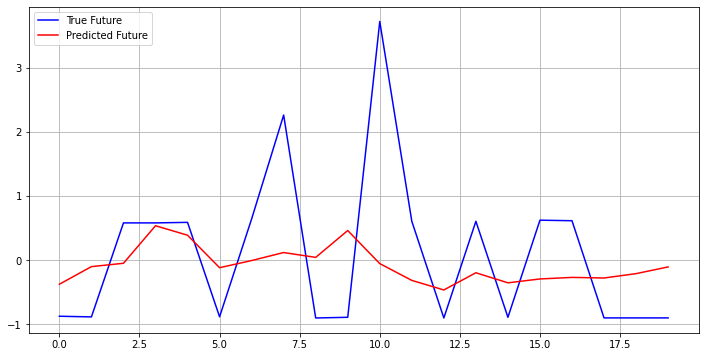

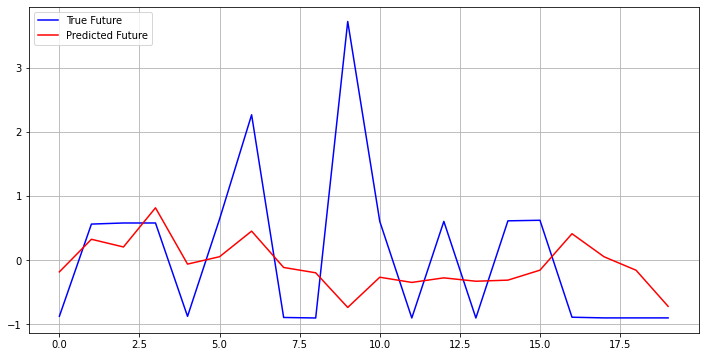

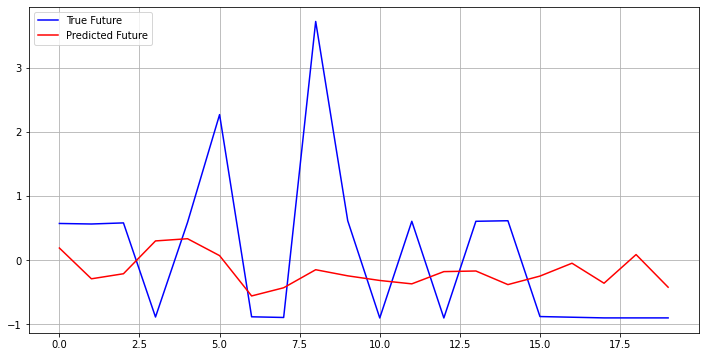

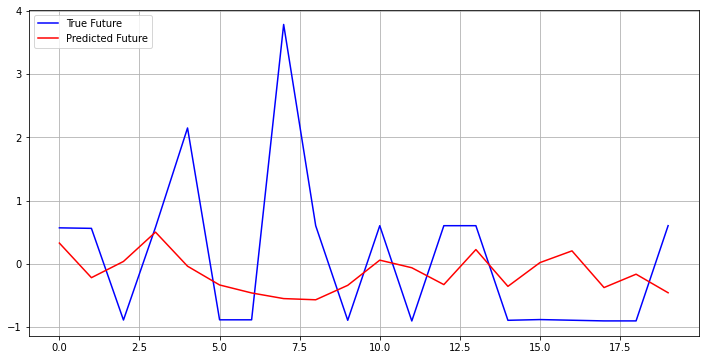

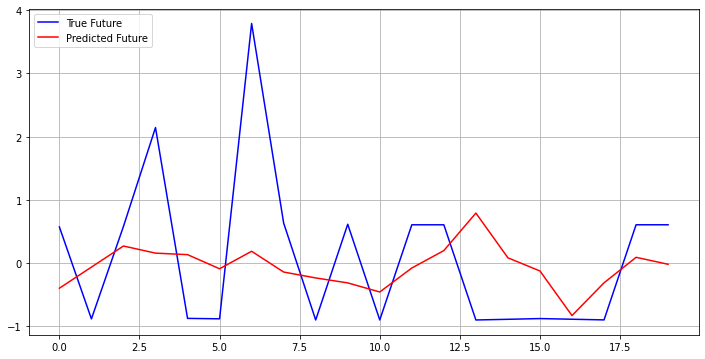

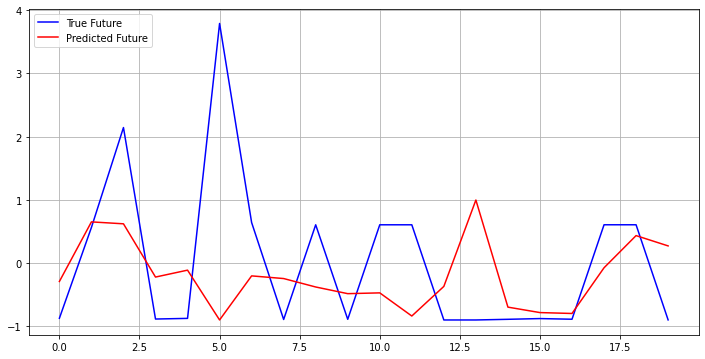

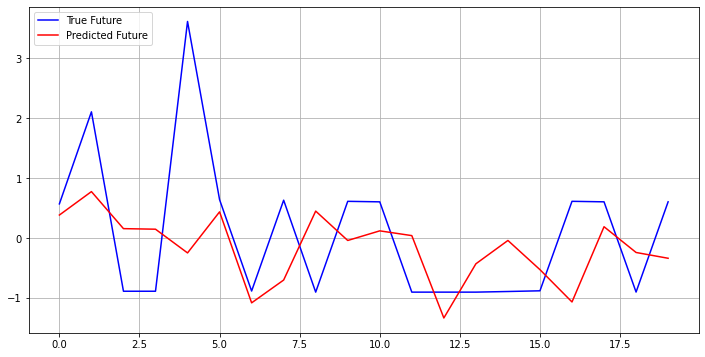

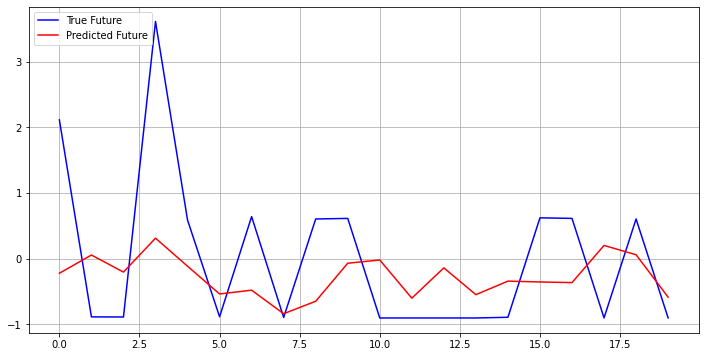

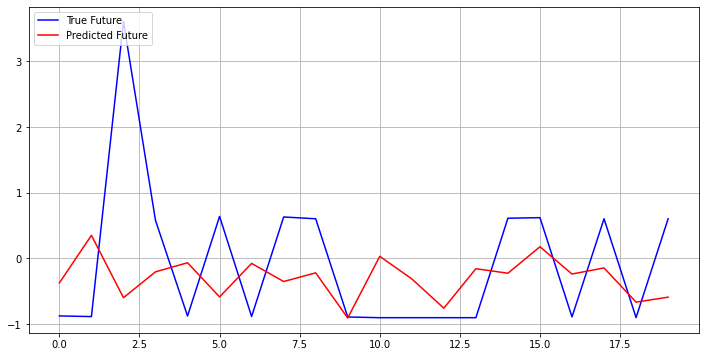

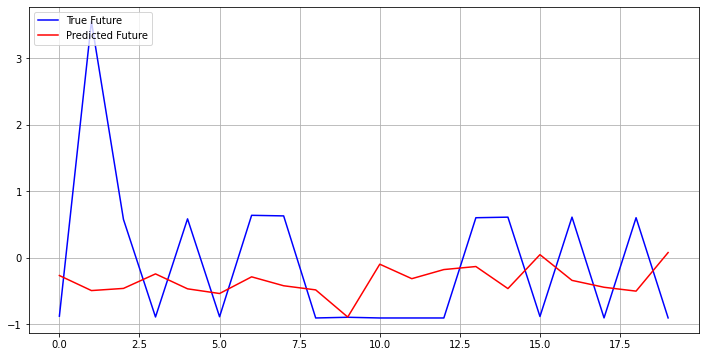

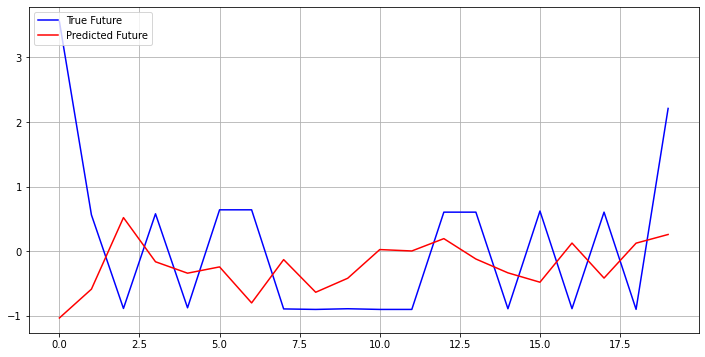

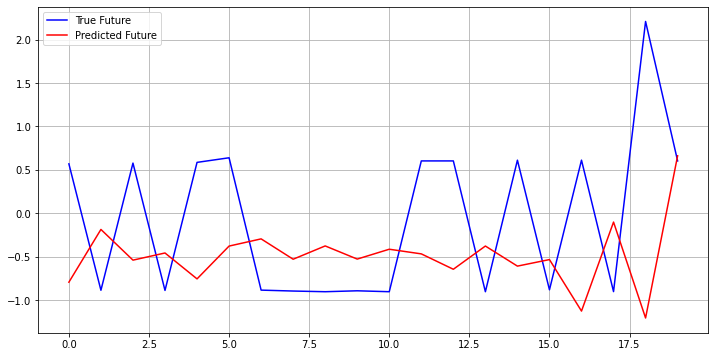

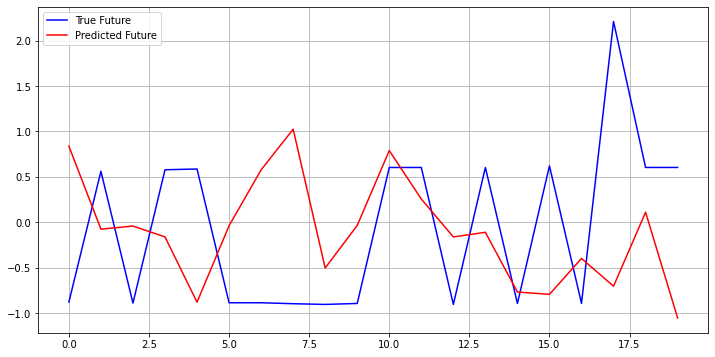

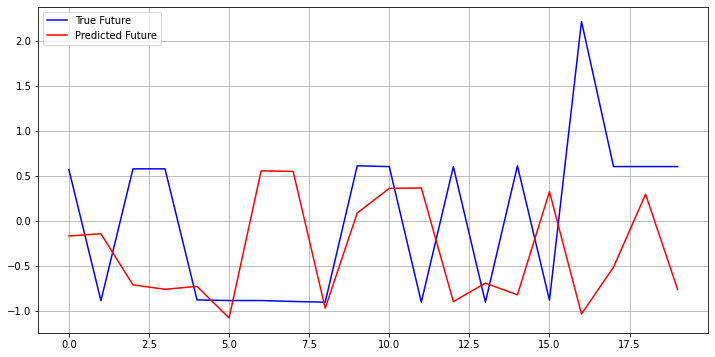

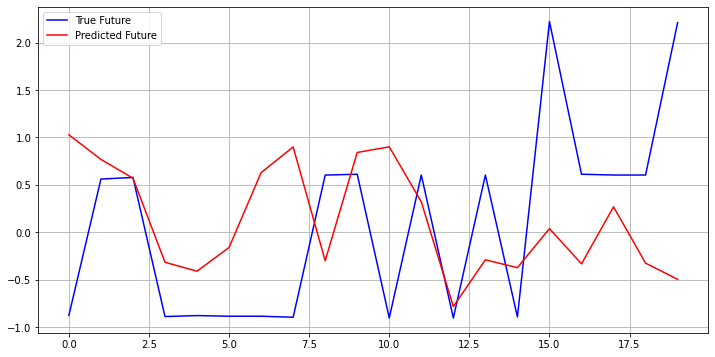

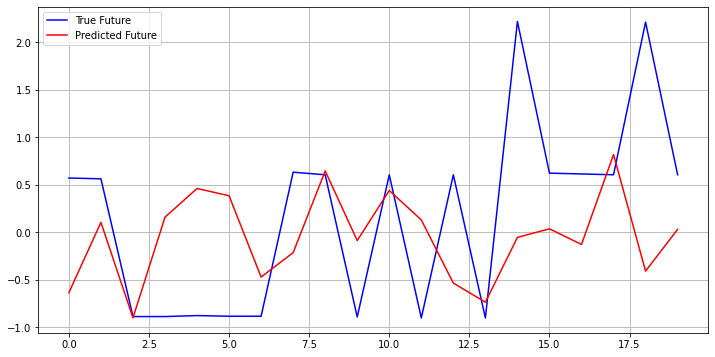

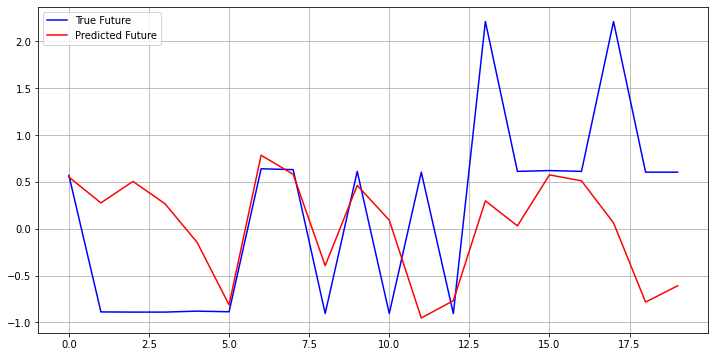

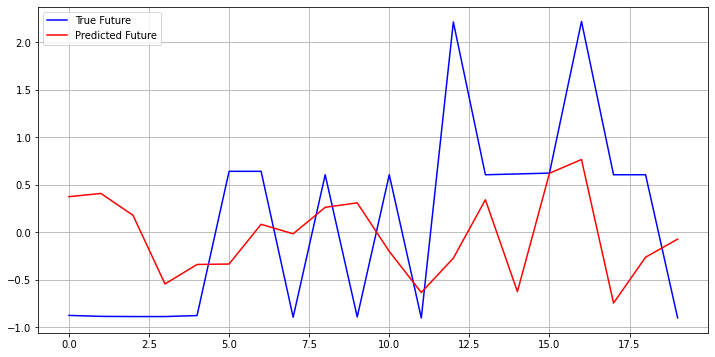

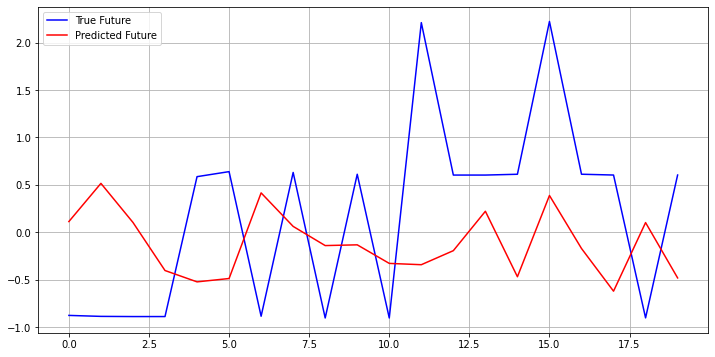

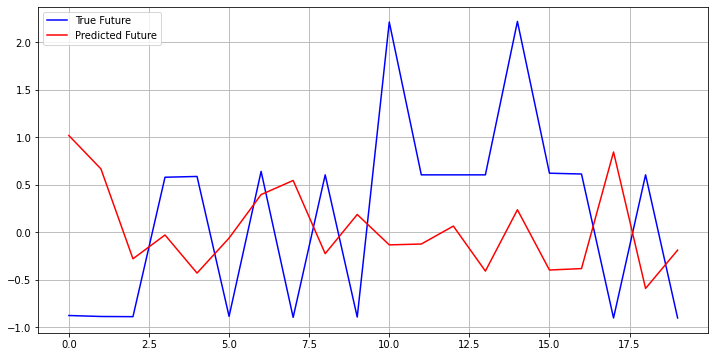

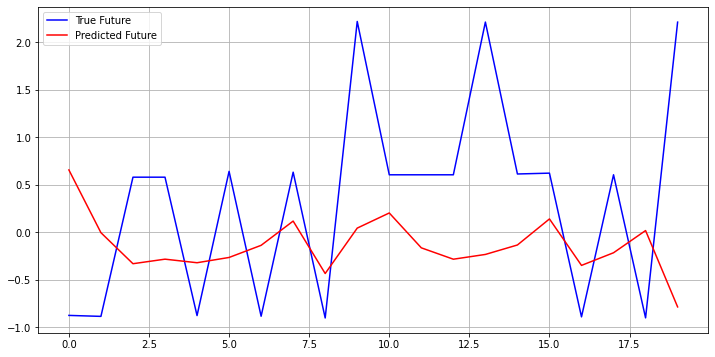

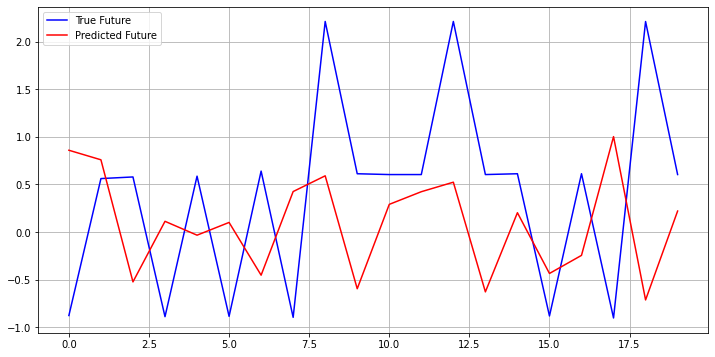

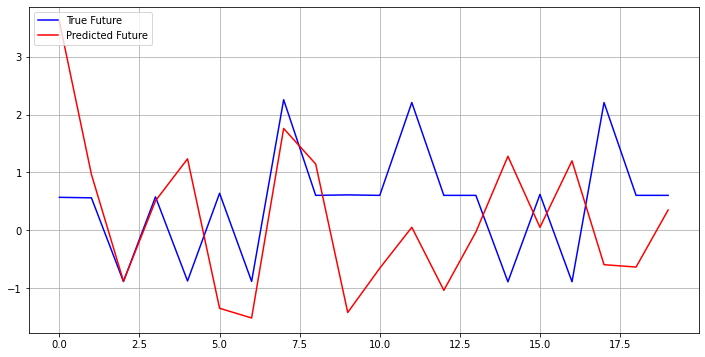

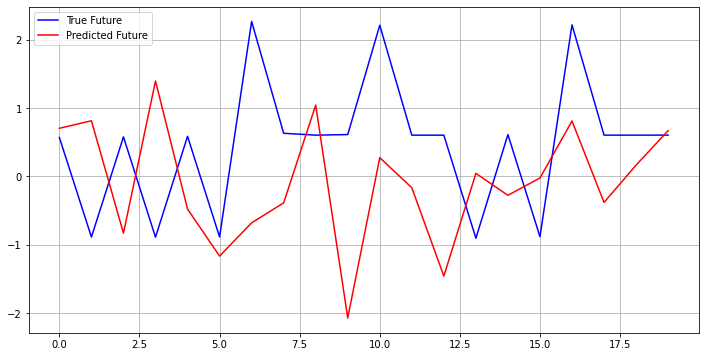

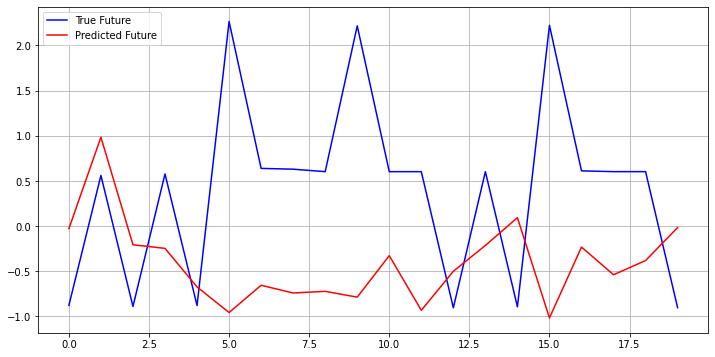

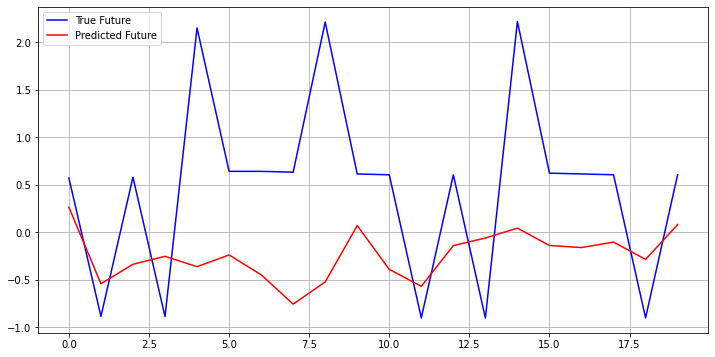

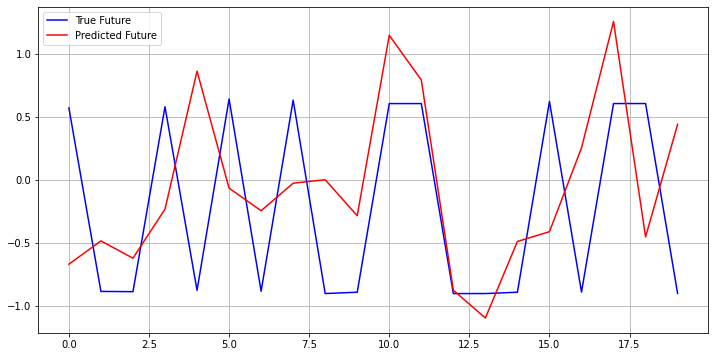

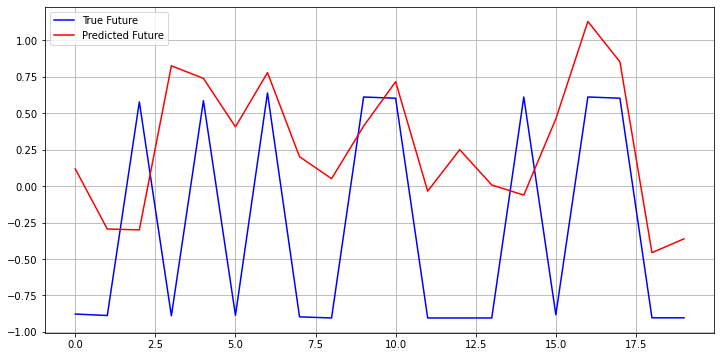

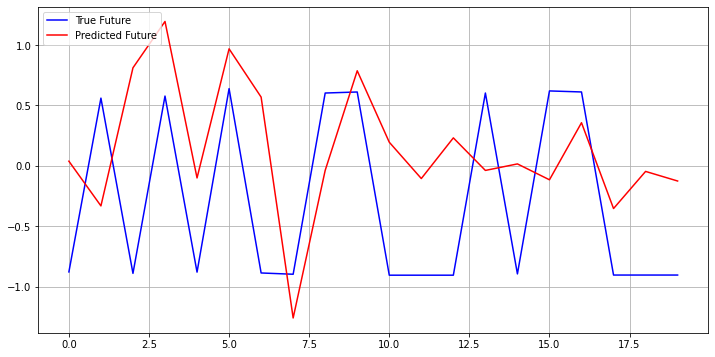

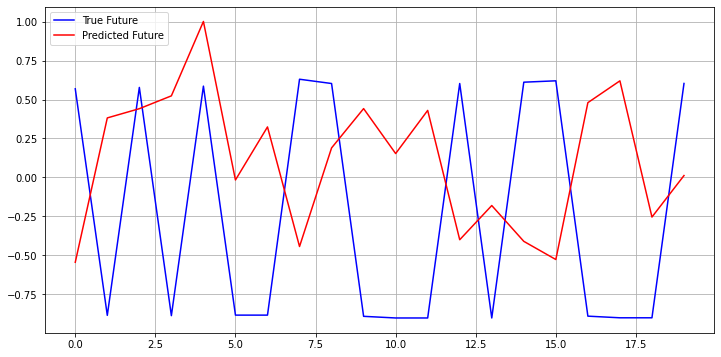

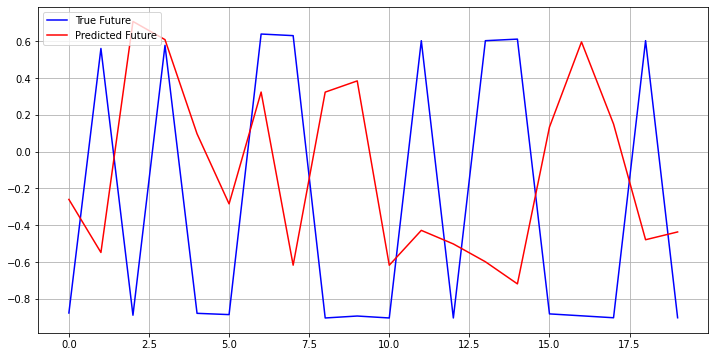

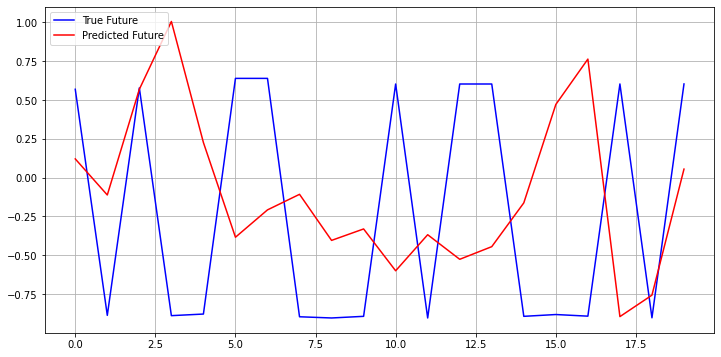

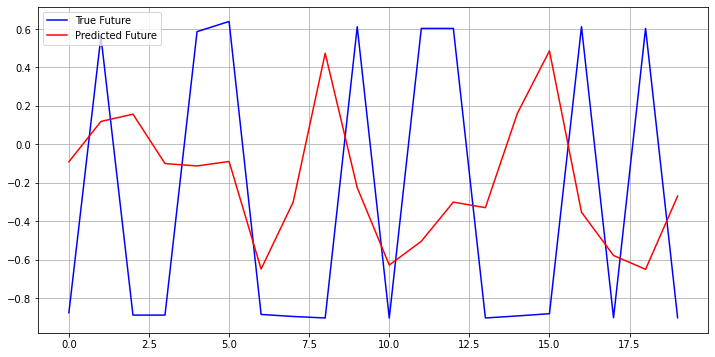

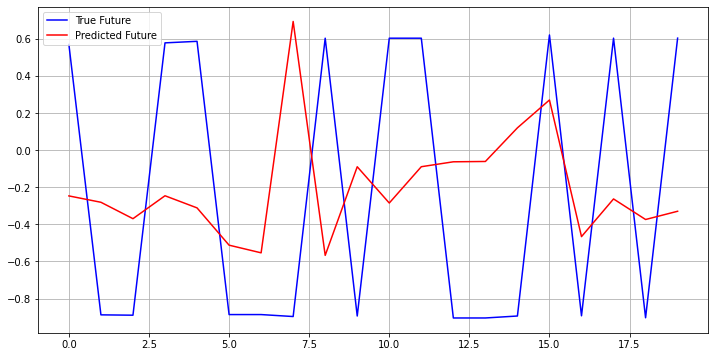

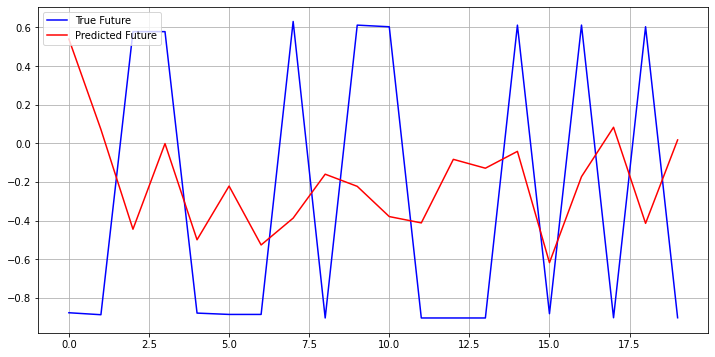

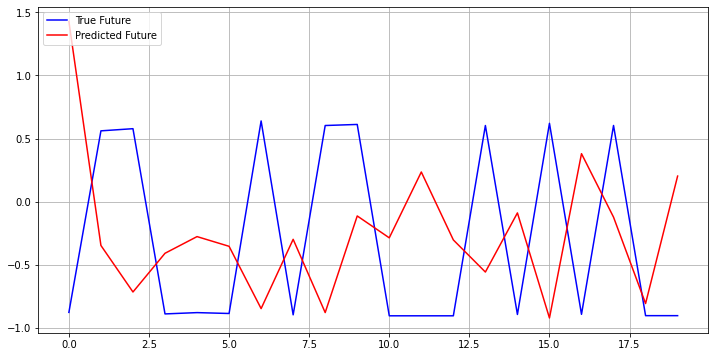

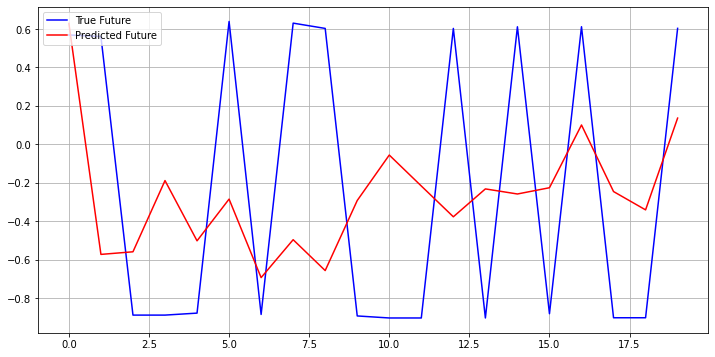

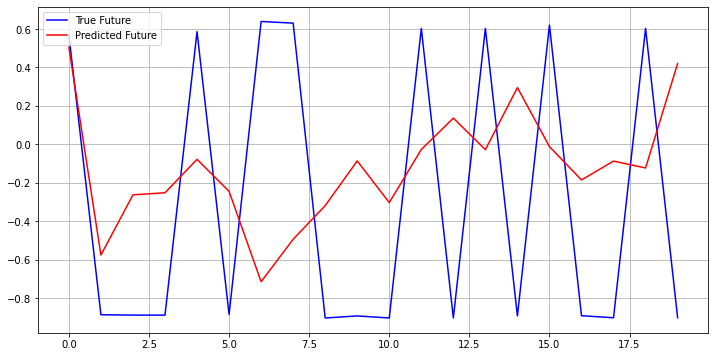

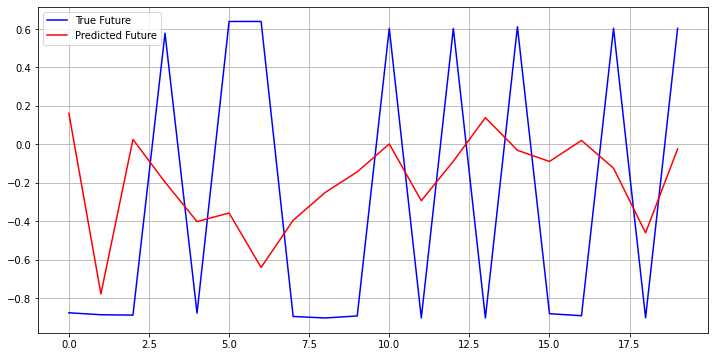

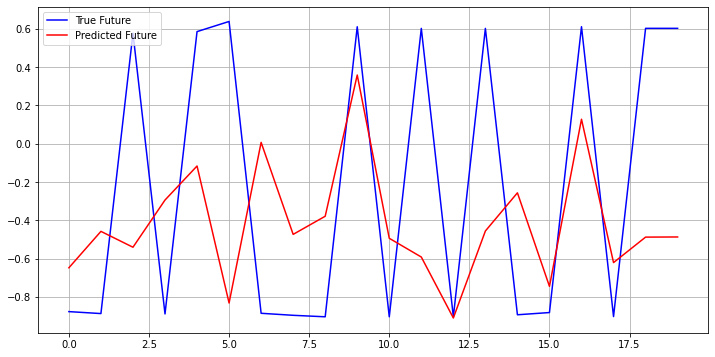

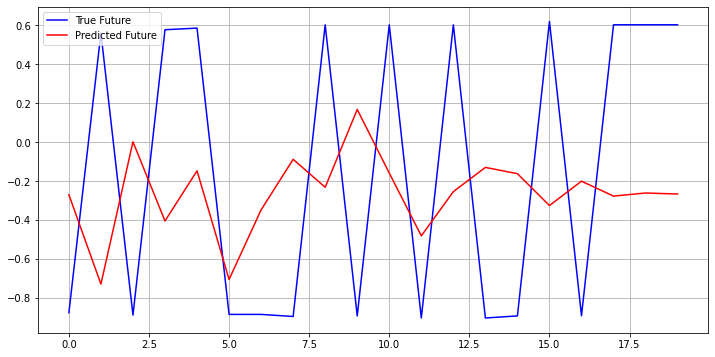

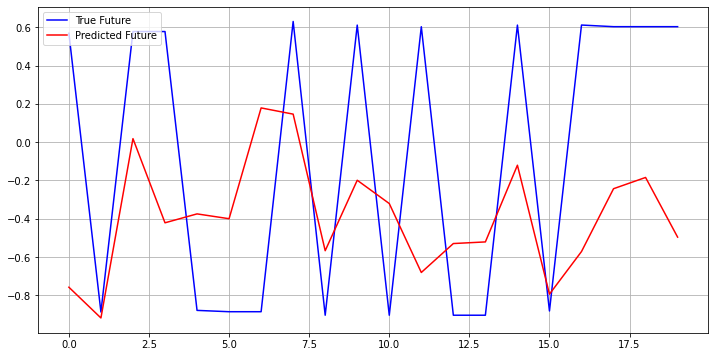

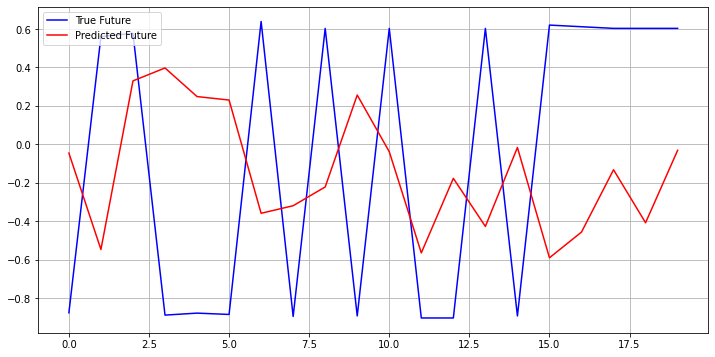

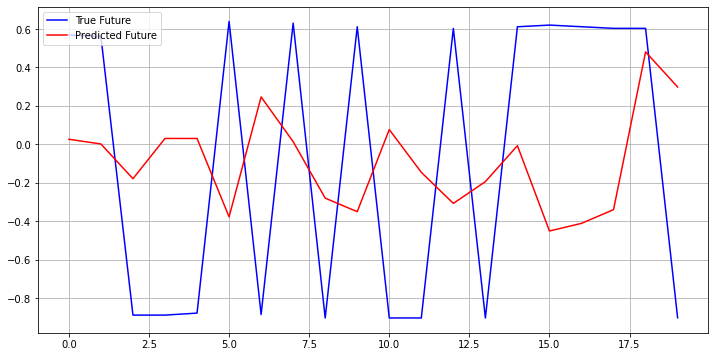

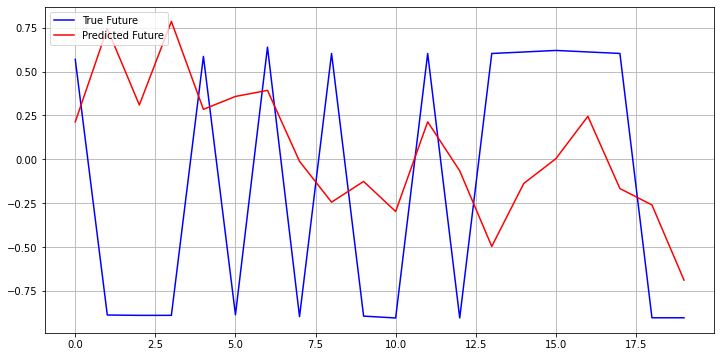

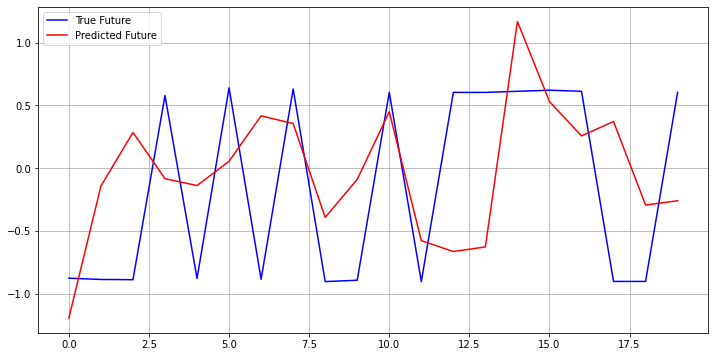

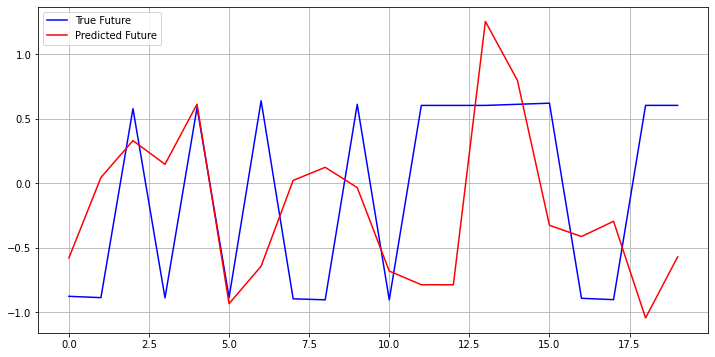

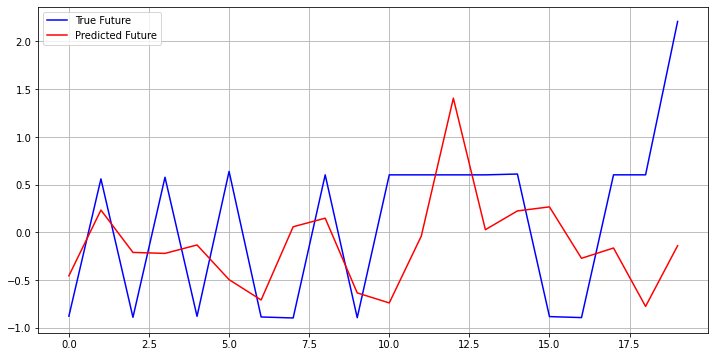

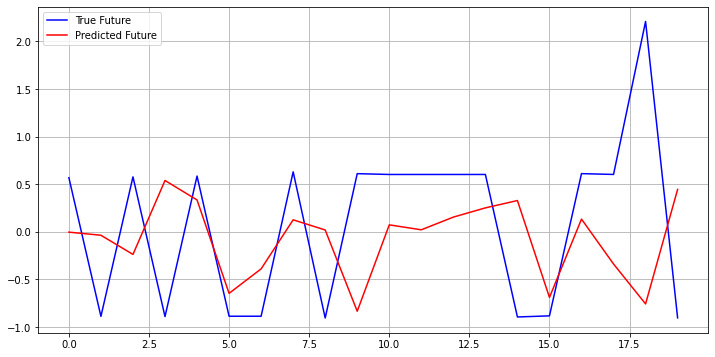

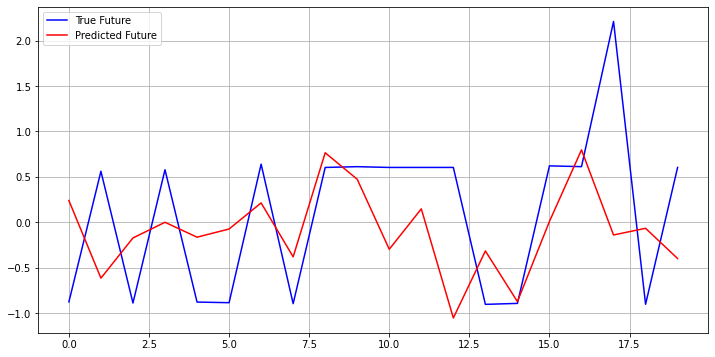

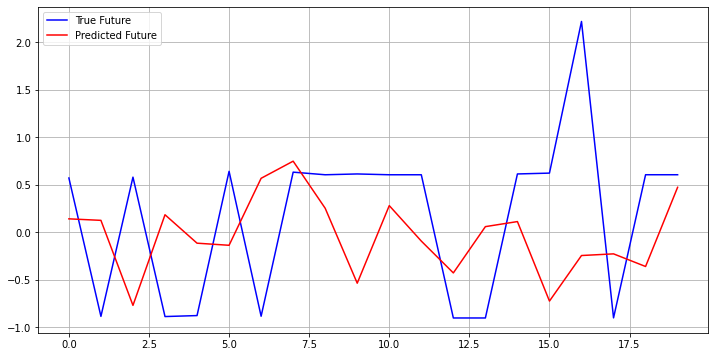

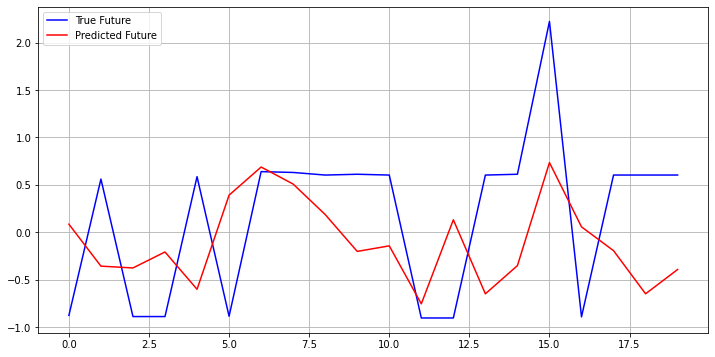

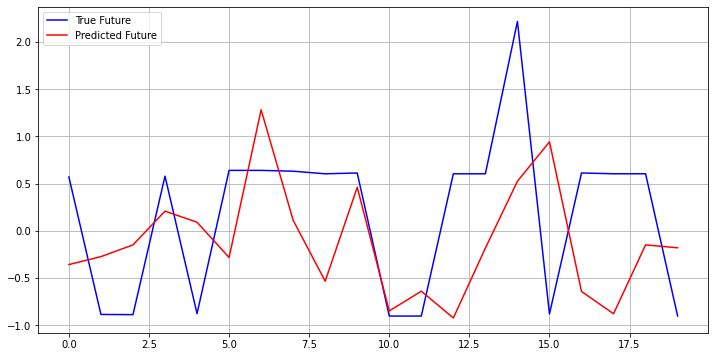

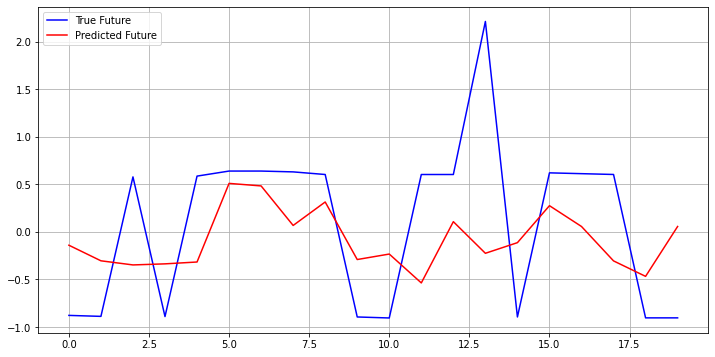

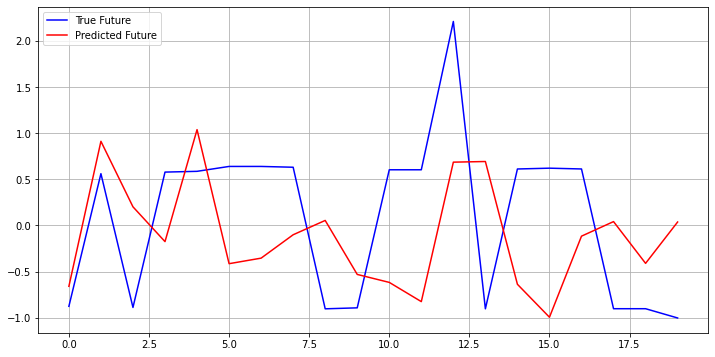

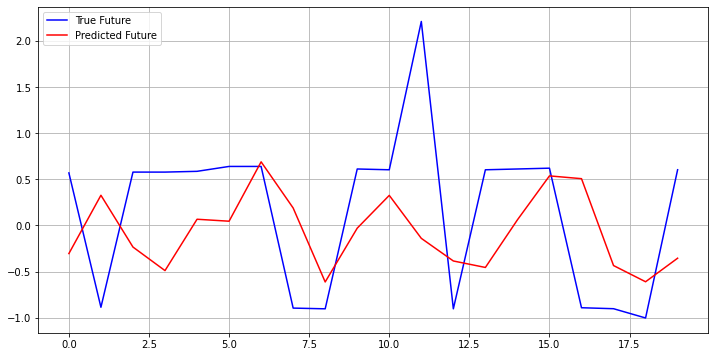

In [21]:
for x, y in test_data_multi:
  try:
    for i in range(30):
     multi_step_plot(x[i], y[i], multi_step_model.predict(x)[i])
  except:
    print(" ")
#Son arrayin x[1] 'i yok. X[0]'ı var sadece.


In [ ]:
model = multi_step_model  # Get model (Sequential, Functional Model, or Model subclass)
model.save('/content/model')


INFO:tensorflow:Assets written to: /content/model\assets


In [ ]:
for x, y in test_data_multi:
  print(x)

In [ ]:
# python outlier detection
!pip install pyod

import warnings
import numpy as np
import pandas as pd
from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [ ]:
def fit_model(model, data, column='amount'):
    # fit the model and predict it
    df = data.copy()
    data_to_predict = data[column].to_numpy().reshape(-1, 1)
    predictions = model.fit_predict(data_to_predict)
    df['Predictions'] = predictions
    
    return df

def plot_anomalies(df, x='date', y='amount'):

    # categories will be having values from 0 to n
    # for each values in 0 to n it is mapped in colormap
    categories = df['Predictions'].to_numpy()
    colormap = np.array(['g', 'r'])

    f = plt.figure(figsize=(12, 4))
    f = plt.scatter(df[x], df[y], c=colormap[categories])
    f = plt.xlabel(x)
    f = plt.ylabel(y)
    f = plt.xticks(rotation=90)
    plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


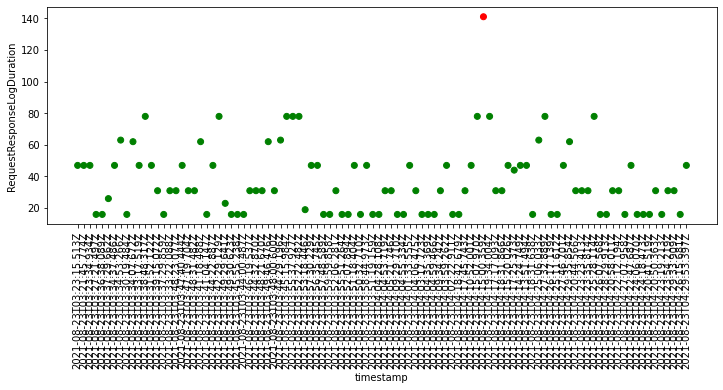

In [ ]:
df = pd.read_csv('/content/logs.csv')[100:200]
df.head()
mad_model = MAD()
mad_df = fit_model(mad_model, df , column = "RequestResponseLogDuration")
plot_anomalies(mad_df,x="timestamp",y="RequestResponseLogDuration")

In [ ]:
iso_forest = IsolationForest(n_estimators=125)
iso_df = fit_model(iso_forest, df , column = "RequestResponseLogDuration")
iso_df['Predictions'] = iso_df['Predictions'].map(lambda x: 1 if x==-1 else 0)
plot_anomalies(iso_df,x="timestamp",y="RequestResponseLogDuration")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


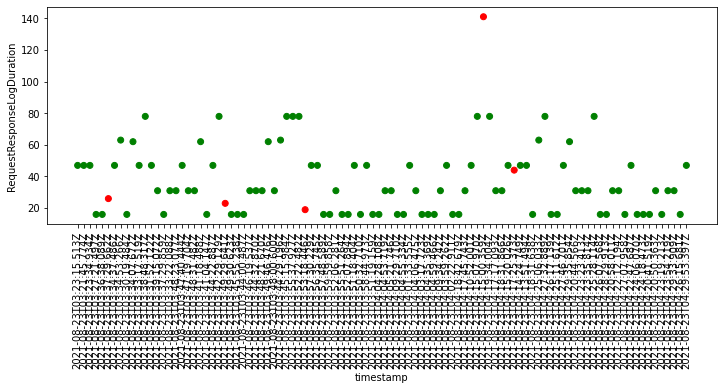

In [ ]:
knn_model = KNN()
knn_df = fit_model(knn_model, df,column = "RequestResponseLogDuration")
plot_anomalies(knn_df,x="timestamp",y="RequestResponseLogDuration")

In [ ]:
!hostname --fqdn

c74335ced258


In [3]:
!pip install keras-tuner

In [5]:
import tensorflow as tf
import kerastuner as kt

In [90]:

steps = int( np.ceil(x_train_multi.shape[0] / batch_size) )
val_steps=int( np.ceil(x_val_multi.shape[0] / batch_size) )
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential API and start stacking the layers
  model = tf.keras.models.Sequential()
  hp_units = hp.Int('input_unit', min_value=64, max_value=512, step=32)
  model.add(tf.keras.layers.LSTM(hp_units,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=True))
  hp_units2 = hp.Int('input_unit2', min_value=64, max_value=512, step=32)
  model.add(tf.keras.layers.LSTM(hp_units,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=True))
  hp_units3 = hp.Int('input_unit3', min_value=64, max_value=512, step=32)
  model.add(tf.keras.layers.LSTM(hp_units,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=True))
  hp_units4 = hp.Int('input_unit4', min_value=64, max_value=512, step=32)
  model.add(tf.keras.layers.LSTM(hp_units,input_shape=x_train_multi.shape[-2:],activation=None,return_sequences=True))
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  # Add next layers
  model.add(Dropout(0.2))
  model.add(tf.keras.layers.Dense(35))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0,learning_rate=hp_learning_rate),
                loss="mae",
                metrics=['mse'])
  return model

In [97]:
# Instantiate the tuner
from kerastuner.tuners import RandomSearch
tuner= RandomSearch(
        model_builder,
        objective='mse',
        max_trials=2,
        executions_per_trial=1
        )


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [99]:
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
INFO:tensorflow:Oracle triggered exit


In [100]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(train_data_multi,epochs=20,batch_size=64) ##Bunun için train datasındaki x ve y nin sizeları eşit olmalı. (30 step geriye 30 step ileriye bakılacak.)

INFO:tensorflow:Oracle triggered exit


In [89]:
best_hp=tuner.get_best_hyperparameters()[0]
print(best_hp)

In [ ]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()
h_model.fit(x_train, x_test, epochs=10, validation_split=0.1)

In [ ]:
import smtplib
from smtplib import SMTPException

sender = 'emircanmuhammed@gmail.com'
receivers = ['dag1.aktifbank.com.tr']

message = """From: From Person <from@fromdomain.com>
To: To Person <to@todomain.com>
Subject: SMTP e-mail test

This is a test e-mail message.
"""

try:
   smtpObj = smtplib.SMTP('sta001vtahatest')
   smtpObj.sendmail(sender, receivers, message)         
   print ("Successfully sent email")
except SMTPException:
   print ("Error: unable to send email")
